# Models Testing on Heston data


In [1]:
import time

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.utils import shuffle

from scipy import stats

import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader

In [2]:
# Set seeds
torch.manual_seed(0)
np.random.seed(0)

In [3]:
options_path = '../data/real_options.csv'

In [4]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')
    
    return df

In [5]:
options_df = pd.read_csv(options_path, index_col=0)
options_df = reduce_mem_usage(options_df)

In [6]:
options_df = shuffle(options_df, random_state=0)
options_df = options_df.reset_index()
options_df['r'] = options_df['r'] / 100
options_df = options_df.drop('index', axis=1)

In [7]:
options_df

,strike,lastPrice,impliedVolatility,type,close,hv_21,hv_42,hv_63,moneyness,tau,r
0,116.25,48.500000,0.524902,call,162.875,0.253662,0.292236,0.306396,1.401367,0.145630,0.008430
1,340.00,0.399902,0.589355,call,195.375,0.650391,0.690918,0.687988,0.574707,0.203247,0.009201
2,270.00,0.070007,0.460938,put,289.750,0.372314,0.355225,0.351807,0.931641,0.002747,0.008408
3,175.00,8.851562,0.283691,put,170.375,0.258057,0.292725,0.302979,1.027344,0.120850,0.007851
4,1500.00,1459.000000,0.000010,call,2490.000,0.645020,0.556152,0.573242,1.660156,0.472412,0.009201
...,...,...,...,...,...,...,...,...,...,...,...
217542,310.00,123.000000,0.596680,put,197.875,0.581055,0.671387,0.687988,1.566406,0.137329,0.008408
217543,220.00,32.562500,0.015640,call,209.875,1.515625,1.135742,1.008789,0.954102,0.741699,0.008430
217544,305.00,33.562500,0.295410,put,289.750,0.372314,0.355225,0.351807,1.052734,0.387451,0.008408
217545,2476.00,61.750000,0.625000,call,1091.000,0.590332,0.614746,0.659180,0.440674,1.200195,0.006832


# Preprocessing

In [8]:
options_df = pd.get_dummies(options_df, prefix='', prefix_sep='')

In [9]:
input_sc = StandardScaler()
output_sc = StandardScaler()
input_data = input_sc.fit_transform(options_df.drop(['lastPrice', 'impliedVolatility', 'hv_42', 'hv_63'], axis=1))
output_data = output_sc.fit_transform(options_df['lastPrice'].values.reshape(-1, 1))

train_size = 0.8
val_size = 0.1

last_train_idx = int(np.round(len(input_data) * train_size))
last_val_idx = last_train_idx + int(np.round(len(input_data) * val_size))

X_train = input_data[0:last_train_idx]
X_val = input_data[last_train_idx:last_val_idx]
X_test = input_data[last_val_idx:]

y_train = output_data[0:last_train_idx]
y_val = output_data[last_train_idx:last_val_idx]
y_test = output_data[last_val_idx:]

In [10]:
df_cols = options_df.drop(['lastPrice', 'impliedVolatility', 'hv_42', 'hv_63'], axis=1).columns
df_cols

Index(['strike', 'close', 'hv_21', 'moneyness', 'tau', 'r', 'call', 'put'], dtype='object')

In [11]:
X_train = Variable(torch.Tensor(X_train))
X_val = Variable(torch.Tensor(X_val))
X_test = Variable(torch.Tensor(X_test))

y_train = Variable(torch.Tensor(y_train))
y_val = Variable(torch.Tensor(y_val))
y_test = Variable(torch.Tensor(y_test))

# Model

In [12]:
CUDA = torch.cuda.is_available()
device = 'cuda:0' if CUDA else 'cpu'

In [13]:
class ResBlock(nn.Module):

  def __init__(self, module):
    super(ResBlock, self).__init__()
    self.module = module

  def forward(self, x):
    return self.module(x) + x

In [14]:
class HiddenLayer(nn.Module):

  def __init__(self, layer_size, act_fn):
      super(HiddenLayer, self).__init__()
      
      if act_fn == 'ReLU':
        self.layer = nn.Sequential(
          nn.Linear(layer_size, layer_size),
          nn.ReLU())
      elif act_fn == 'LeakyReLU':
        self.layer = nn.Sequential(
          nn.Linear(layer_size, layer_size),
          nn.LeakyReLU())
      elif act_fn == 'ELU':
        self.layer = nn.Sequential(
          nn.Linear(layer_size, layer_size),
          nn.ELU())
    
  def forward(self, x):
    return self.layer(x)

In [15]:
class Net(nn.Module):

  def __init__(self, input_size, output_size, hidden_size, num_layers, act_fn):
    super(Net, self).__init__()
    self.input_size = input_size
    self.output_size = output_size
    self.hidden_size = hidden_size

    if act_fn == 'ReLU':
      self.initial_layer = nn.Sequential(
          nn.Linear(self.input_size, self.hidden_size),
          nn.ReLU())
    elif act_fn == 'LeakyReLU':
      self.initial_layer = nn.Sequential(
          nn.Linear(self.input_size, self.hidden_size),
          nn.LeakyReLU())
    elif act_fn == 'ELU':
      self.initial_layer = nn.Sequential(
          nn.Linear(self.input_size, self.hidden_size),
          nn.ELU())

    self.hidden_layers_list = []

    for i in range(num_layers // 2):
      self.hidden_layers_list.append(
          ResBlock(
            nn.Sequential(
                HiddenLayer(self.hidden_size, act_fn),
                HiddenLayer(self.hidden_size, act_fn)
            )
        )
      )

    self.hidden_layers = nn.Sequential(*self.hidden_layers_list)

    self.net = nn.Sequential(
        self.initial_layer,
        self.hidden_layers,
        nn.Linear(self.hidden_size, self.output_size)
    )
  
  def forward(self, x):
    return self.net(x)

In [16]:
def init_weights(m, init_m: str):

  @torch.no_grad()
  def init_uniform(m):
    if isinstance(m, nn.Linear):
      torch.nn.init.uniform_(m.weight)
      m.bias.data.fill_(0.01)

  @torch.no_grad()
  def init_normal(m):
    if isinstance(m, nn.Linear):
      torch.nn.init.normal_(m.weight)
      m.bias.data.fill_(0.01)

  @torch.no_grad()
  def init_xuniform(m):
    if isinstance(m, nn.Linear):
      torch.nn.init.xavier_uniform_(m.weight)
      m.bias.data.fill_(0.01)

  @torch.no_grad()
  def init_xnormal(m):
    if isinstance(m, nn.Linear):
      torch.nn.init.xavier_normal_(m.weight)
      m.bias.data.fill_(0.01)

  if init_m == 'uniform':
    m.apply(init_uniform)
  elif init_m == 'normal':
    m.apply(init_normal)
  elif init_m == 'xaiver uniform':
    m.apply(init_xuniform)
  elif init_m == 'xavier normal':
    m.apply(init_xnormal)

# Training

In [17]:
input_size = 8
output_size = 1
num_layers = 8
hidden_size = 800
batch_size = 1213
epochs = 2000
lr = 0.00068
init_method = 'xaiver uniform'
act_fn = 'ReLU'

model = Net(input_size, output_size, hidden_size, num_layers, act_fn)
init_weights(model, init_method)

loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [18]:
model = model.to(device)

X_train = X_train.to(device)
y_train = y_train.to(device)

X_val = X_val.to(device)
y_val = y_val.to(device)

X_test = X_test.to(device)
y_test = y_test.to(device)

In [19]:
class OptDataset(Dataset):

  def __init__(self, X, y):
    self.X = X
    self.y = y

  def __getitem__(self, idx):
    return self.X[idx], self.y[idx]

  def __len__(self):
    return len(self.X)

### Losses Metrics

In [20]:
def MAPELoss(output, target):
  return torch.mean(torch.abs((target - output) / target))

In [21]:
def evaluate(model, loss_fn, X_val, y_val):
  model.eval()
  with torch.no_grad():
    out = model(X_val)
    loss = loss_fn(out, y_val)
    print('\nVal set: Average loss: {:.8f}\n'.format(
            loss.item()))
    return loss.item()

### Early Stopping class

In [22]:
# Code took form: https://github.com/Bjarten/early-stopping-pytorch/blob/master/pytorchtools.py

class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, 
                 patience=10, 
                 verbose=False, 
                 delta=0, 
                 path='../models/final_heston_model.chkpt',
                 trace_func=print):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement.
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
            trace_func (function): trace print function.
                            Default: print
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func

    def __call__(self, val_loss, model):

        score = val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score > self.best_score + self.delta:
            self.counter += 1
            self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

### Train Loop

In [23]:
def train(
    epochs,
    batch_size,
    model,
    optimizer,
    loss_fn,
    X_train,
    y_train,
    X_val,
    y_val
):

  training_losses = []
  validation_losses = []

  early_stopping = EarlyStopping(patience=20)

  for epoch in range(epochs):
    model.train()
    epoch_losses = []
    total_loss = 0
    start_time = time.time()
    i = 0

    for batch, batch_labels in DataLoader(OptDataset(X_train, y_train), batch_size=batch_size):
      out = model(batch.to(device))
      optimizer.zero_grad()

      loss = loss_fn(out, batch_labels.to(device))
      epoch_losses.append(loss.item())
      total_loss += loss.item()
      loss.backward()
      optimizer.step()

      if i > 0 and i % 50 == 0:
        avg_loss = total_loss / 50
        elapsed = time.time() - start_time
        print('| Epoch {:3d} | {:5d}/{:5d} batches | lr {:2.5f} | ms/batch {:5.2f} | '
                  'loss {:5.8f}'.format(
              epoch, i, len(X_train) // batch_size+1, lr, elapsed * 1000 / 50,
              avg_loss))
        start_time = time.time()
        total_loss = 0

      i += 1

    training_losses.append(np.array(epoch_losses).mean())
    val_loss = evaluate(model, loss_fn, X_val, y_val)
    validation_losses.append(val_loss)

    early_stopping(val_loss, model)

    if early_stopping.early_stop:
        print(f"Stopping at Epoch: {epoch}")
        break

  return training_losses, validation_losses

In [24]:
load = False
save_model_path = '../models/final_real_data_model.chkpt'
val_err_df_path = '../results/val_final_real_data_model.csv'

if not load:
  train_losses, val_losses = train(
      epochs,
      batch_size,
      model,
      optimizer,
      loss_fn,
      X_train,
      y_train,
      X_val,
      y_val)
  val_err_df = pd.DataFrame({
      'Training': train_losses,
      'Validation': val_losses})
  val_err_df.to_csv(val_err_df_path)
  torch.save(model.state_dict(), save_model_path)
else:
  model = Net(input_size, output_size, hidden_size, num_layers, act_fn)
  model.load_state_dict(torch.load(save_model_path, map_location=device))
  model = model.to(device)
  val_err_df = pd.read_csv(val_err_df_path, index_col=0)

| Epoch   0 |    50/  144 batches | lr 0.00068 | ms/batch 44.85 | loss 0.87298324
| Epoch   0 |   100/  144 batches | lr 0.00068 | ms/batch 38.34 | loss 0.14754409

Val set: Average loss: 0.13159057

| Epoch   1 |    50/  144 batches | lr 0.00068 | ms/batch 38.33 | loss 0.12356914
| Epoch   1 |   100/  144 batches | lr 0.00068 | ms/batch 36.78 | loss 0.12312661

Val set: Average loss: 0.11905827

| Epoch   2 |    50/  144 batches | lr 0.00068 | ms/batch 39.21 | loss 0.10457141
| Epoch   2 |   100/  144 batches | lr 0.00068 | ms/batch 36.55 | loss 0.09978281

Val set: Average loss: 0.12044018

EarlyStopping counter: 1 out of 20
| Epoch   3 |    50/  144 batches | lr 0.00068 | ms/batch 37.10 | loss 0.09624446
| Epoch   3 |   100/  144 batches | lr 0.00068 | ms/batch 35.25 | loss 0.09342015

Val set: Average loss: 0.10429933

| Epoch   4 |    50/  144 batches | lr 0.00068 | ms/batch 37.40 | loss 0.09009929
| Epoch   4 |   100/  144 batches | lr 0.00068 | ms/batch 35.24 | loss 0.08759400



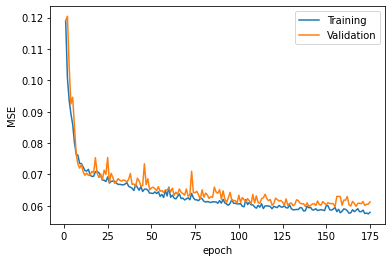

In [25]:
val_err_df[1:].plot(xlabel='epoch', ylabel='MSE')
plt.plot();

# Test the model

In [26]:
model.eval();

In [27]:
test_size = 30

with torch.no_grad():
    test_out = model(X_test[0:test_size])

test_out = output_sc.inverse_transform(test_out.cpu().detach().numpy())
real_out = output_sc.inverse_transform(y_test[0:test_size].cpu().detach().numpy())

In [32]:
cols = ['strike', 'close', 'hv_21', 'moneyness', 'tau', 'r',
       'call', 'put']
test_options = pd.DataFrame(input_sc.inverse_transform(X_test[0:test_size].detach().cpu().numpy()), columns=cols)

In [34]:
test_options['Prediction'] = test_out
test_options['Real'] = real_out
test_options

,strike,close,hv_21,moneyness,tau,r,call,put,Prediction,Real
0,168.130478,1094.110352,0.595204,0.153761,0.217177,0.005150,-0.000044,1.000044,3.580143,0.835361
1,1900.244019,1009.010193,0.556156,0.531474,2.175713,0.008362,0.999914,0.000086,184.174286,169.994904
2,420.016449,289.492157,0.372215,0.689547,0.214165,0.008408,0.999914,0.000086,-2.991131,0.024723
3,414.875916,179.259857,0.322410,0.431638,0.219779,0.005298,0.999914,0.000086,144.796707,116.472633
4,509.853302,199.831390,1.548694,2.556479,0.049287,0.009201,-0.000044,1.000044,268.504913,297.447205
5,639.835266,187.022736,0.464121,0.291867,0.222518,0.008431,0.999914,0.000086,19.672764,0.024723
6,120.152206,211.087494,0.780288,1.759768,1.126194,0.009201,0.999914,0.000086,85.863930,94.707047
7,1600.135010,1045.980713,0.620141,1.529417,0.543954,0.006859,-0.000044,1.000044,527.555969,530.018738
8,570.070923,1009.010193,0.556156,0.564752,0.079688,0.008362,-0.000044,1.000044,0.448353,0.511112
9,3089.909424,2489.868652,0.645044,0.806023,0.049287,0.009201,0.999914,0.000086,8.256046,2.132389


In [35]:
test_options['Abs Error'] = np.abs(test_options.Prediction - test_options.Real)

In [36]:
test_options.sort_values('Abs Error')

,strike,close,hv_21,moneyness,tau,r,call,put,Prediction,Real,Abs Error
8,570.070923,1009.010193,0.556156,0.564752,0.079688,0.008362,-0.000044,1.000044,0.448353,0.511112,0.062759
13,990.003174,998.045227,0.554195,1.008190,0.395475,0.008431,0.999914,0.000086,159.906036,160.490189,0.584152
21,799.987183,1099.932495,0.595703,0.726986,0.469714,0.005298,-0.000044,1.000044,55.219318,53.850986,1.368332
17,1179.835571,1022.498169,0.581059,0.865924,0.101599,0.007851,0.999914,0.000086,23.040897,21.587650,1.453247
16,275.347290,283.281891,0.366849,0.970752,0.313310,0.008232,-0.000044,1.000044,15.948902,17.534473,1.585571
26,649.871521,881.481323,0.645044,0.736969,0.486327,0.008232,-0.000044,1.000044,51.232502,52.878223,1.645721
7,1600.135010,1045.980713,0.620141,1.529417,0.543954,0.006859,-0.000044,1.000044,527.555969,530.018738,2.462769
11,599.934937,1091.005249,0.590320,0.549777,0.008205,0.006832,-0.000044,1.000044,2.687366,0.024723,2.662643
0,168.130478,1094.110352,0.595204,0.153761,0.217177,0.005150,-0.000044,1.000044,3.580143,0.835361,2.744781
2,420.016449,289.492157,0.372215,0.689547,0.214165,0.008408,0.999914,0.000086,-2.991131,0.024723,3.015854


### MSE on the test set

In [37]:
model.eval()
with torch.no_grad():
    out = model(X_test)
    loss = loss_fn(out, y_test)
    print('The MSE on the test set is: ', loss.item())

The MSE on the test set is:  0.06431712210178375


### MAE on the test set

In [38]:
model.eval()
mae_loss = nn.L1Loss()
with torch.no_grad():
    out = model(X_test)
    loss = mae_loss(out, y_test)
    print('The MAE on the test set is: ', loss.item())

The MAE on the test set is:  0.08930504322052002


### RSME on the test set

In [39]:
model.eval()
with torch.no_grad():
    out = model(X_test)
    loss = loss_fn(out, y_test)
    print('The RMSE on the test set is: ', np.sqrt(loss.item()))

The RMSE on the test set is:  0.25360820590387795


### MAPE on the test set

In [40]:
model.eval()
with torch.no_grad():
    out = model(X_test)
    loss = MAPELoss(out, y_test).item()
    print('The MAPE on the test set is: ', loss)

The MAPE on the test set is:  0.3327904939651489


### $R^2$

In [41]:
from sklearn.metrics import r2_score

model.eval()
with torch.no_grad():
    out = model(X_test).squeeze().cpu().detach().numpy()

y_true = y_test.cpu().squeeze().detach().numpy()

r2 = r2_score(y_pred=out, y_true=y_true)

print('the R^2 score is: ', r2)

the R^2 score is:  0.9360338935876047


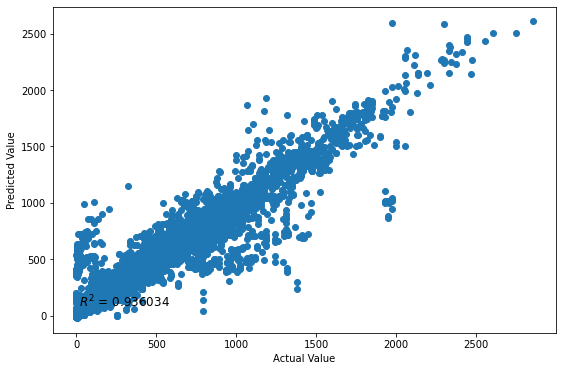

In [42]:
fig = plt.figure(figsize=(9, 6))
ax = fig.add_subplot()

ax.scatter(
    y=output_sc.inverse_transform(out.reshape(-1, 1)),
    x=output_sc.inverse_transform(y_true.squeeze().reshape(-1, 1))
)
ax.set_xlabel('Actual Value')
ax.set_ylabel('Predicted Value')

ax.text(20, 80, f'$R^2$ = {np.round(r2, 6)}', fontsize=12)

plt.show()

## Greeks

In [43]:
def get_d1_d2(S, X, T, t, r, sigma):
    """
    Compute d1 and d2 values for the black-scholes pricing model


    :param S: underlying price
    :param X: option's strike price
    :param T: option's time to maturity (in years)
    :param t: current time (in years)
    :param r: interest rate
    :param sigma: underlying volatility
    :return: (d1, d2)
    """
    d1 = (np.log(S / X) + (r + sigma * sigma / 2.) * (T - t)) / (sigma * np.sqrt(T - t))
    d2 = d1 - sigma * np.sqrt(T - t)
    return d1, d2


def black_scholes(S, X, T, t, r, sigma, o_type: str = "C") -> np.single:
    """
    Compute option price using the black-scholes model

    :param S: underlying price
    :param X: option's strike price
    :param T: option's time to maturity (in years)
    :param t: current time (in years)
    :param r: interest rate (in percentual)
    :param sigma: underlying volatility
    :param o_type: option type, "C" for a call option and "P" for a put option
    :return: the black-scholes option price
    """
    d1, d2 = get_d1_d2(S, X, T, t, r, sigma)
    if o_type == "C":
        return S * stats.norm.cdf(d1, 0, 1) - X * np.exp(-r * (T - t)) * stats.norm.cdf(d2, 0, 1)
    else:
        return X * np.exp(-r * (T - t)) * stats.norm.cdf(-d2, 0, 1) - S * stats.norm.cdf(-d1, 0, 1)


def delta_fdm_bs(S, X, sigma, tau, r, delta_S, o_type: str = 'C'):
  return (black_scholes(S + delta_S, X, tau, 0, r, sigma, o_type) - black_scholes(S, X, tau, 0, r, sigma, o_type)) / delta_S

def theta_fdm_bs(S, X, sigma, tau, r, delta_tau, o_type: str = 'C'):
  return (black_scholes(S, X, tau + delta_tau, 0, r, sigma, o_type) - black_scholes(S, X, tau, 0, r, sigma, o_type)) / delta_tau

def vega_fdm_bs(S, X, sigma, tau, r, delta_sigma, o_type: str = 'C'):
  return (black_scholes(S, X, tau, 0, r, sigma + delta_sigma, o_type) - black_scholes(S, X, tau, 0, r, sigma, o_type)) / delta_sigma

def delta_fdm_net(S, X, sigma_1, m, tau, r, delta_S, o_type: str = 'C'):
  c = 1 if o_type == 'C' else 0
  p = 1 if o_type == 'P' else 0
  input_df_1 = pd.DataFrame(np.array([[X, S + delta_S, sigma_1, m, r,  tau,  c, p]]), columns=df_cols)
  input_df_2 = pd.DataFrame(np.array([[X, S, sigma_1,  m, r,  tau,  c, p]]), columns=df_cols)
  net_input_1 = torch.Tensor(
      input_sc.transform(input_df_1)).to(device)
  net_input_2 = torch.Tensor(
      input_sc.transform(input_df_2)).to(device)
  sc_output_1 = output_sc.inverse_transform(model(net_input_1).detach().cpu().numpy())
  sc_output_2 = output_sc.inverse_transform(model(net_input_2).detach().cpu().numpy())
  return (sc_output_1 - sc_output_2) / delta_S


def theta_fdm_net(S, X, sigma_1, m, tau, r, delta_tau, o_type: str = 'C'):
  c = 1 if o_type == 'C' else 0
  p = 1 if o_type == 'P' else 0
  input_df_1 = pd.DataFrame(np.array([[X, S, sigma_1, m, r,  tau + delta_tau,  c, p]]), columns=df_cols)
  input_df_2 = pd.DataFrame(np.array([[X, S, sigma_1, m, r,  tau,  c, p]]), columns=df_cols)
  net_input_1 = torch.Tensor(
      input_sc.transform(input_df_1)).to(device)
  net_input_2 = torch.Tensor(
      input_sc.transform(input_df_2)).to(device)
  sc_output_1 = output_sc.inverse_transform(model(net_input_1).detach().cpu().numpy())
  sc_output_2 = output_sc.inverse_transform(model(net_input_2).detach().cpu().numpy())
  return (sc_output_1 - sc_output_2) / delta_tau


def vega_fdm_net(S, X, sigma_1, m, tau, r, delta_sigma, o_type: str = 'C'):
  c = 1 if o_type == 'C' else 0
  p = 1 if o_type == 'P' else 0
  input_df_1 = pd.DataFrame(np.array([[X, S, sigma_1 + delta_sigma, m, r,  tau,  c, p]]), columns=df_cols)
  input_df_2 = pd.DataFrame(np.array([[X, S, sigma_1, m, r,  tau,  c, p]]), columns=df_cols)
  net_input_1 = torch.Tensor(
      input_sc.transform(input_df_1)).to(device)
  net_input_2 = torch.Tensor(
      input_sc.transform(input_df_2)).to(device)
  sc_output_1 = output_sc.inverse_transform(model(net_input_1).detach().cpu().numpy())
  sc_output_2 = output_sc.inverse_transform(model(net_input_2).detach().cpu().numpy())
  return (sc_output_1 - sc_output_2) / delta_sigma

In [44]:
test_size = 30

with torch.no_grad():
    test_out = model(X_test[0:test_size])

test_out = output_sc.inverse_transform(test_out.cpu().detach().numpy())
real_out = output_sc.inverse_transform(y_test[0:test_size].cpu().detach().numpy())

In [46]:
model.zero_grad()
inp_g = X_test[0].clone().detach().requires_grad_(True)
test_out_g = model(inp_g)

In [47]:
grad_ns = torch.autograd.grad(test_out_g, inp_g, retain_graph=True)[0].data
grad_ns

tensor([-3.3260e-02,  5.4478e-02,  5.6752e-02,  8.1515e-01,  7.4593e-02,
        -1.8408e-04,  2.1228e-01, -2.1125e-01], device='cuda:0')

In [48]:
input_sc.inverse_transform(grad_ns.detach().cpu().numpy().reshape(1, -1))

array([[8.8285150e+02, 8.8745239e+02, 5.8673936e-01, 1.3020522e+01,
        5.4139084e-01, 7.6687844e-03, 6.2236869e-01, 3.7814638e-01]],
      dtype=float32)

In [ ]:
998.045227, 990.003174, 0.554195, 0.395475, 0.008431, 'C'

In [57]:
delta_fdm_bs(998.045227, 990.003174, 0.554195, 0.395475, 0.008431, 0.1, 'C')

0.5820663402130322

In [60]:
delta_fdm_net(998.045227, 990.003174, 0.554195, 998.045227 / 990.003174, 0.395475, 0.008431, 0.1,'C')

array([[0.32714844]], dtype=float32)

In [61]:
theta_fdm_bs(998.045227, 990.003174, 0.554195, 0.395475, 0.008431, 0.0027, 'C') / 364

0.4810723834326066

In [72]:
theta_fdm_net(998.045227, 990.003174, 0.554195, 998.045227 / 990.003174, 0.395475, 0.008431, 0.0027, 'C') / 364

array([[10.518689]], dtype=float32)

In [64]:
vega_fdm_bs(998.045227, 990.003174, 0.554195, 0.395475, 0.008431, 0.01, 'C')

245.01700202394545

In [63]:
vega_fdm_net(998.045227, 990.003174, 0.554195, 998.045227 / 990.003174,0.395475, 0.008431, 0.01, 'C')

array([[180.0415]], dtype=float32)